In [1]:
# YOLOv11 Bilgi Damıtma - Sadece İleri Seviye KD Yöntemi
# Bu betik, sahte etiketleme adımını atlayarak doğrudan özellik/yanıt
# seviyesinde bilgi damıtma (fine-tuning) yapar.

# ==============================================================================
# BÖLÜM 1: RUNTIME & KURULUM
# ==============================================================================
print("Bölüm 1: Kütüphaneler kuruluyor ve ortam hazırlanıyor...")

import os
import shutil
import yaml
from pathlib import Path
import torch
import torch.nn as nn

# Gerekli kütüphaneleri yükle (Colab ortamında çalışır)
os.system("pip -q install ultralytics>=8.3.0 roboflow>=1.1.29 --upgrade")

from ultralytics import YOLO
from ultralytics.utils import callbacks
from roboflow import Roboflow

print('Ultralytics Sürümü:', __import__('ultralytics').__version__)
print('PyTorch Sürümü:', torch.__version__)
print("-" * 50)


# ==============================================================================
# BÖLÜM 2: PROJE YAPILANDIRMASI
# ==============================================================================
print("Bölüm 2: Proje parametreleri ayarlanıyor...")

# === Roboflow Bilgileri (LÜTFEN DOLDURUN) ===
RF_API_KEY = 'bVCHIdUmWTMSr6ETOu3O'  # LÜTFEN ROBOFLOW API ANAHTARINIZI BURAYA GİRİN
WORKSPACE  = 'computer-vision-yqyos'
PROJECT    = 'merged-cracks'
VERSION    = 2

# === Model Seçimleri ===
TEACHER_MODEL = 'yolo11l.pt'
STUDENT_MODEL = 'yolo11n.pt'

# === Eğitim Parametreleri ===
teacher_epochs = 50
student_base_epochs = 100 # Öğrencinin temel eğitimi için
kd_finetune_epochs = 50   # İleri KD hassas ayarı için
imgsz = 640
batch = -1
patience = 25

# === İleri Seviye KD Ayarları ===
kd_logit_weight   = 1.0
kd_feature_weight = 0.2

# === Dizin Yapılandırması ===
BASE_DIR   = Path.cwd() / 'yolo11_advanced_kd'
TEACHER_DIR= BASE_DIR / 'teacher'
STUDENT_DIR= BASE_DIR / 'student'
for p in [BASE_DIR, TEACHER_DIR, STUDENT_DIR]:
    p.mkdir(parents=True, exist_ok=True)
print('Çalışma Dizini:', BASE_DIR)
print("-" * 50)


# ==============================================================================
# BÖLÜM 3: ROBOFLOW'DAN VERİSETİNİ İNDİR
# ==============================================================================
print("Bölüm 3: Roboflow'dan veriseti indiriliyor...")

assert RF_API_KEY, 'Lütfen 2. bölümdeki RF_API_KEY değişkenini doldurun.'
rf = Roboflow(api_key=RF_API_KEY)
project = rf.workspace(WORKSPACE).project(PROJECT)
dataset = project.version(VERSION).download('yolov11')
DATASET_DIR = Path(dataset.location)
ORIGINAL_DATA_YAML = DATASET_DIR / 'data.yaml'
print(f"✅ Veriseti başarıyla indirildi: {DATASET_DIR}")
print("-" * 50)


# ==============================================================================
# BÖLÜM 4: ÖĞRETMEN MODELİNİ EĞİT
# ==============================================================================
print("Bölüm 4: Öğretmen modeli eğitiliyor...")

device = 0 if torch.cuda.is_available() else 'cpu'
print(f"Kullanılan Cihaz: {device}")

teacher = YOLO(TEACHER_MODEL)

teacher.train(
    data=str(ORIGINAL_DATA_YAML),
    epochs=teacher_epochs,
    imgsz=imgsz,
    batch=batch,
    patience=patience,
    project=str(TEACHER_DIR),
    name='teacher_training',
    device=device
)

best_teacher_path = teacher.trainer.best
print(f"✅ Öğretmen eğitimi tamamlandı. En iyi model: {best_teacher_path}")
print("-" * 50)


# ==============================================================================
# BÖLÜM 5: ÖĞRENCİ MODELİNİ TEMEL VERİ SETİYLE EĞİT
# ==============================================================================
print("Bölüm 5: Öğrenci modeli orijinal veri setiyle eğitiliyor (temel model)...")

student = YOLO(STUDENT_MODEL)

student.train(
    data=str(ORIGINAL_DATA_YAML),
    epochs=student_base_epochs,
    imgsz=imgsz,
    batch=batch,
    patience=patience,
    project=str(STUDENT_DIR),
    name='student_base_training',
    device=device
)

best_student_path = student.trainer.best
print(f"✅ Öğrenci temel eğitimi tamamlandı. En iyi model: {best_student_path}")
print("-" * 50)


# ==============================================================================
# BÖLÜM 6: İLERİ SEVİYE KD İLE HASSAS AYAR
# ==============================================================================
print("Bölüm 6: İleri seviye KD ile hassas ayar yapılıyor...")

# === Modelleri Yeniden Yükle ===
print(f"Öğretmen modeli yükleniyor: {best_teacher_path}")
print(f"Temel öğrenci modeli yükleniyor: {best_student_path}")

teacher = YOLO(best_teacher_path)
student = YOLO(best_student_path)

teacher.model.to(device).eval()
student.model.to(device)

# === Gerekli Fonksiyonlar ve Sınıflar ===
def get_module_by_path(root: nn.Module, path: str):
    m = root
    for n in path.split('.'):
        m = getattr(m, n)
    return m

class KDCombinedLoss(nn.Module):
    def __init__(self, logit_weight=1.0, feature_weight=0.2, T=2.0):
        super().__init__()
        self.logit_weight = logit_weight
        self.feature_weight = feature_weight
        self.T = T
        self.kl = nn.KLDivLoss(reduction="batchmean")
        self.mse = nn.MSELoss()

    def _flatten_logits(self, logits):
        if isinstance(logits, tuple):
            logits = logits[0]
        return torch.cat([o.view(o.shape[0], -1) for o in logits], dim=1)

    def logit_kd(self, s_logits, t_logits):
        s_flat = self._flatten_logits(s_logits)
        t_flat = self._flatten_logits(t_logits)
        return (self.T**2) * self.kl(
            torch.nn.functional.log_softmax(s_flat / self.T, dim=1),
            torch.nn.functional.softmax(t_flat / self.T, dim=1)
        )

    def feature_mse(self, s_feats, t_feats):
        loss = 0.0
        if not s_feats or not t_feats: return torch.tensor(0.0, device=device)
        for s, t in zip(s_feats.values(), t_feats.values()):
            if s.shape != t.shape:
                t = torch.nn.functional.interpolate(t, size=s.shape[-2:], mode="nearest")
            loss += self.mse(s, t)
        return loss / len(s_feats) if s_feats else 0.0

    def forward(self, s_logits, t_logits, s_feats, t_feats):
        l_log = self.logit_kd(s_logits, t_logits) * self.logit_weight
        l_fea = self.feature_mse(s_feats, t_feats) * self.feature_weight
        total_kd_loss = l_log + l_fea
        return total_kd_loss, {"kd_logit": l_log.detach(), "kd_feat": l_fea.detach()}

kd_loss_fn = KDCombinedLoss(kd_logit_weight, kd_feature_weight, T=2.0).to(device)

class FeatureHook:
    def __init__(self, hook_dict, layer_name):
        self.hook_dict = hook_dict
        self.layer_name = layer_name
    def __call__(self, module, input, output):
        self.hook_dict[self.layer_name] = output

tea_feats, stu_feats = {}, {}
_TEACHER_HOOKS, _STUDENT_HOOKS = [], []
feature_layers = ['model.6', 'model.8', 'model.10']

def attach_hooks(model, hook_dict, hook_list, layer_names):
    for h in hook_list: h.remove()
    hook_list.clear()
    for name in layer_names:
        try:
            module = get_module_by_path(model, name)
            hook = FeatureHook(hook_dict, name)
            handle = module.register_forward_hook(hook)
            hook_list.append(handle)
        except Exception as e:
            print(f"⚠️ Hook eklenemedi: {name} ({e})")

# === Callback Fonksiyonları ===
def on_train_start(trainer):
    attach_hooks(teacher.model, tea_feats, _TEACHER_HOOKS, feature_layers)
    attach_hooks(student.model, stu_feats, _STUDENT_HOOKS, feature_layers)

def on_before_loss(trainer):
    imgs = trainer.batch["img"]
    stu_logits = trainer.preds
    with torch.no_grad():
        tea_logits_output = teacher.model(imgs)
        tea_logits = tea_logits_output[0] if isinstance(tea_logits_output, tuple) else tea_logits_output
    kd_loss, kd_parts = kd_loss_fn(stu_logits, tea_logits, stu_feats, tea_feats)
    trainer.loss += kd_loss
    if hasattr(trainer, 'label_loss_items'):
        trainer.label_loss_items.update(kd_parts)

# === Eğitimi Başlat ===
print("🔰 İleri Seviye KD ile Hassas Ayar Başlatılıyor...")

student.callbacks = callbacks.get_default_callbacks()
student.add_callback("on_train_start", on_train_start)
student.add_callback("on_before_loss", on_before_loss)

student.train(
    data=str(ORIGINAL_DATA_YAML),
    epochs=kd_finetune_epochs,
    imgsz=imgsz,
    batch=batch,
    patience=patience,
    project=str(STUDENT_DIR),
    name='student_final_kd_finetune',
    device=device
)

print("✅ KD ile Hassas Ayar Tamamlandı!")
print("-" * 50)

# ==============================================================================
# BÖLÜM 7: SONUÇLARI İNDİR
# ==============================================================================
print("Bölüm 7: Sonuçlar sıkıştırılıp indiriliyor...")

output_filename = 'yolo11_advanced_kd_results'
print(f"'{BASE_DIR}' klasörü sıkıştırılıyor...")
shutil.make_archive(output_filename, 'zip', BASE_DIR)
print(f"Sıkıştırma tamamlandı: '{output_filename}.zip' oluşturuldu.")

try:
    from google.colab import files
    print("İndirme başlatılıyor...")
    files.download(f'{output_filename}.zip')
except ImportError:
    print("Bu kod Google Colab dışında çalıştırıldığı için otomatik indirme yapılamadı.")
    print(f"Lütfen '{output_filename}.zip' dosyasını manuel olarak indirin.")

print("-" * 50)
print("Tüm işlemler tamamlandı.")


Bölüm 1: Kütüphaneler kuruluyor ve ortam hazırlanıyor...
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics Sürümü: 8.3.214
PyTorch Sürümü: 2.8.0+cu126
--------------------------------------------------
Bölüm 2: Proje parametreleri ayarlanıyor...
Çalışma Dizini: /content/yolo11_advanced_kd
--------------------------------------------------
Bölüm 3: Roboflow'dan veriseti indiriliyor...
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to merged-cracks-2 in yolov11:: 100%|██████████| 22098/22098 [00:02<00:00, 7856.04it/s] 


✅ Veriseti başarıyla indirildi: /content/merged-cracks-2
--------------------------------------------------
Bölüm 4: Öğretmen modeli eğitiliyor...
Kullanılan Cihaz: 0
Ultralytics 8.3.214 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/merged-cracks-2/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11l.pt, momentu

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------------------------------------
Tüm işlemler tamamlandı.


Eğitim sonuçları görselleştirme betiği başlatıldı...
Öğretmen sonuçları aranıyor: /content/yolo11_advanced_kd/teacher/teacher_training/results.csv
Temel öğrenci sonuçları aranıyor: /content/yolo11_advanced_kd/student/student_base_training/results.csv
KD öğrenci sonuçları aranıyor: /content/yolo11_advanced_kd/student/student_final_kd_finetune/results.csv

✅ Karşılaştırma grafiği başarıyla oluşturuldu ve kaydedildi!
   Dosya Yolu: /content/yolo11_advanced_kd/kd_performance_comparison.png


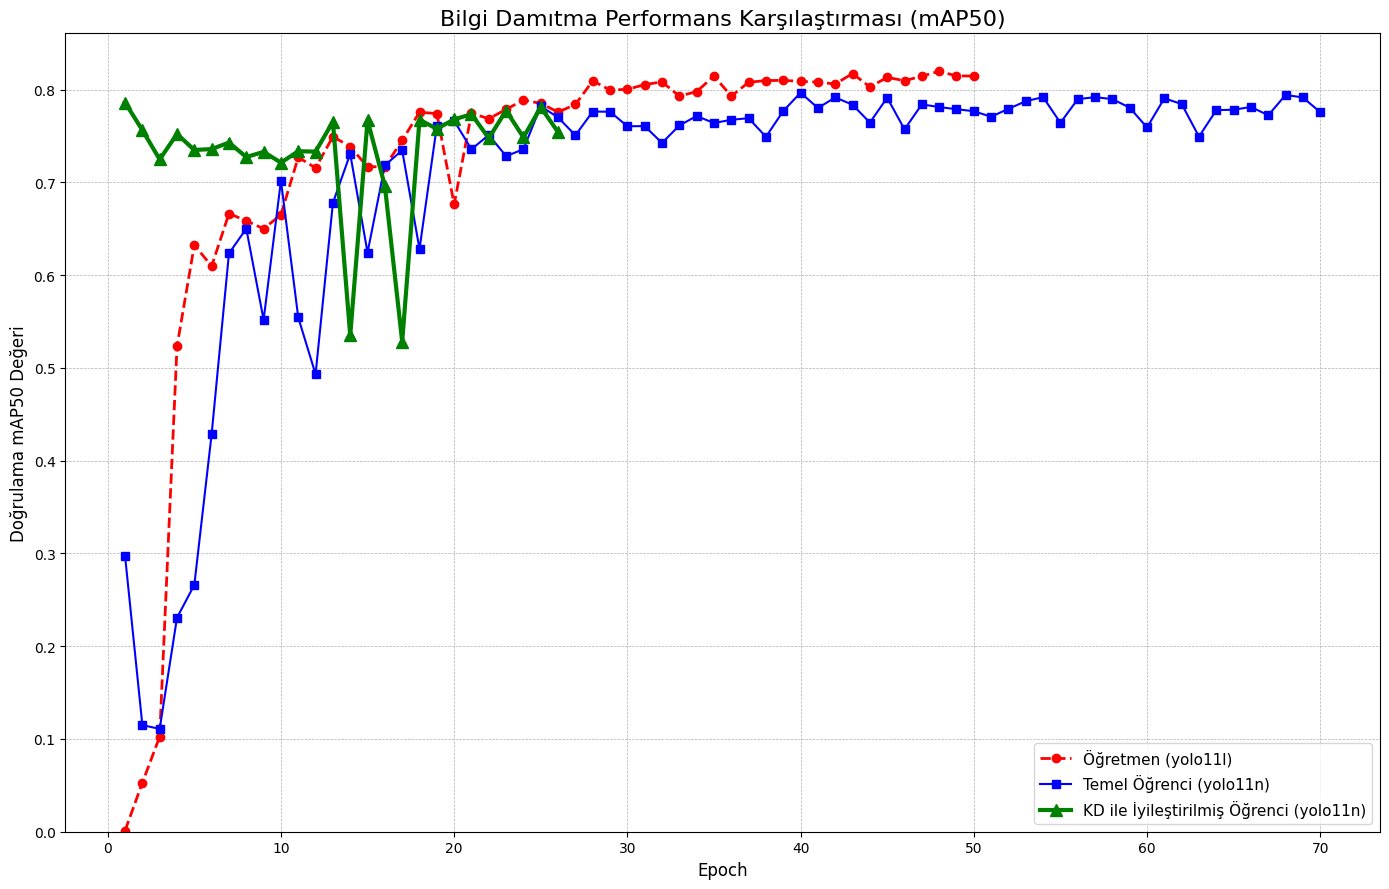

In [2]:
# YOLOv11 Bilgi Damıtma - Sonuç Görselleştirme Betiği
# Bu betik, daha önce tamamlanmış eğitimlerin sonuçlarını okur ve
# karşılaştırmalı bir performans grafiği oluşturur.

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

print("Eğitim sonuçları görselleştirme betiği başlatıldı...")

# --- Dizin Ayarları ---
# Lütfen bu dizinlerin Colab'deki yapınızla eşleştiğinden emin olun.
BASE_DIR = Path.cwd() / 'yolo11_advanced_kd'
TEACHER_DIR = BASE_DIR / 'teacher'
STUDENT_DIR = BASE_DIR / 'student'

# Eğitim klasörlerinin tam yollarını tanımla
teacher_results_path = TEACHER_DIR / 'teacher_training' / 'results.csv'
student_base_results_path = STUDENT_DIR / 'student_base_training' / 'results.csv'
student_kd_results_path = STUDENT_DIR / 'student_final_kd_finetune' / 'results.csv'

print(f"Öğretmen sonuçları aranıyor: {teacher_results_path}")
print(f"Temel öğrenci sonuçları aranıyor: {student_base_results_path}")
print(f"KD öğrenci sonuçları aranıyor: {student_kd_results_path}")

# --- Görselleştirme ---
try:
    # CSV dosyalarını oku
    df_teacher = pd.read_csv(teacher_results_path)
    df_student_base = pd.read_csv(student_base_results_path)
    df_student_kd = pd.read_csv(student_kd_results_path)

    # Sütun adlarındaki olası boşlukları temizle
    for df in [df_teacher, df_student_base, df_student_kd]:
        df.columns = df.columns.str.strip()

    # Grafiği oluştur
    plt.figure(figsize=(14, 9))
    plt.plot(df_teacher['epoch'], df_teacher['metrics/mAP50(B)'], label='Öğretmen (yolo11l)', marker='o', linestyle='--', color='red', linewidth=2)
    plt.plot(df_student_base['epoch'], df_student_base['metrics/mAP50(B)'], label='Temel Öğrenci (yolo11n)', marker='s', color='blue')
    plt.plot(df_student_kd['epoch'], df_student_kd['metrics/mAP50(B)'], label='KD ile İyileştirilmiş Öğrenci (yolo11n)', marker='^', color='green', linewidth=3, markersize=8)

    # Grafiği zenginleştir
    plt.title('Bilgi Damıtma Performans Karşılaştırması (mAP50)', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Doğrulama mAP50 Değeri', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.ylim(bottom=0)
    plt.tight_layout()

    # Grafiği kaydet
    save_path = BASE_DIR / 'kd_performance_comparison.png'
    plt.savefig(save_path, dpi=150)

    print("\n" + "="*50)
    print(f"✅ Karşılaştırma grafiği başarıyla oluşturuldu ve kaydedildi!")
    print(f"   Dosya Yolu: {save_path}")
    print("="*50)

    # Grafiği Colab'de göster
    plt.show()

except FileNotFoundError as e:
    print(f"\n❌ HATA: Grafik çizilemedi. Sonuç dosyası bulunamadı.")
    print(f"   Eksik dosya: {e.filename}")
    print("   Lütfen eğitimlerin tamamlandığından ve klasör yollarının doğru olduğundan emin olun.")
except Exception as e:
    print(f"\n❌ HATA: Grafik çizilirken beklenmedik bir sorun oluştu: {e}")


Akademik sonuçları görselleştirme betiği başlatıldı...
Öğretmen sonuçları aranıyor: /content/yolo11_advanced_kd/teacher/teacher_training/results.csv
Temel öğrenci sonuçları aranıyor: /content/yolo11_advanced_kd/student/student_base_training/results.csv
KD öğrenci sonuçları aranıyor: /content/yolo11_advanced_kd/student/student_final_kd_finetune/results.csv

✅ Akademik analiz grafikleri başarıyla oluşturuldu ve kaydedildi!
   Dosya Yolu: /content/yolo11_advanced_kd/kd_academic_performance_analysis.png


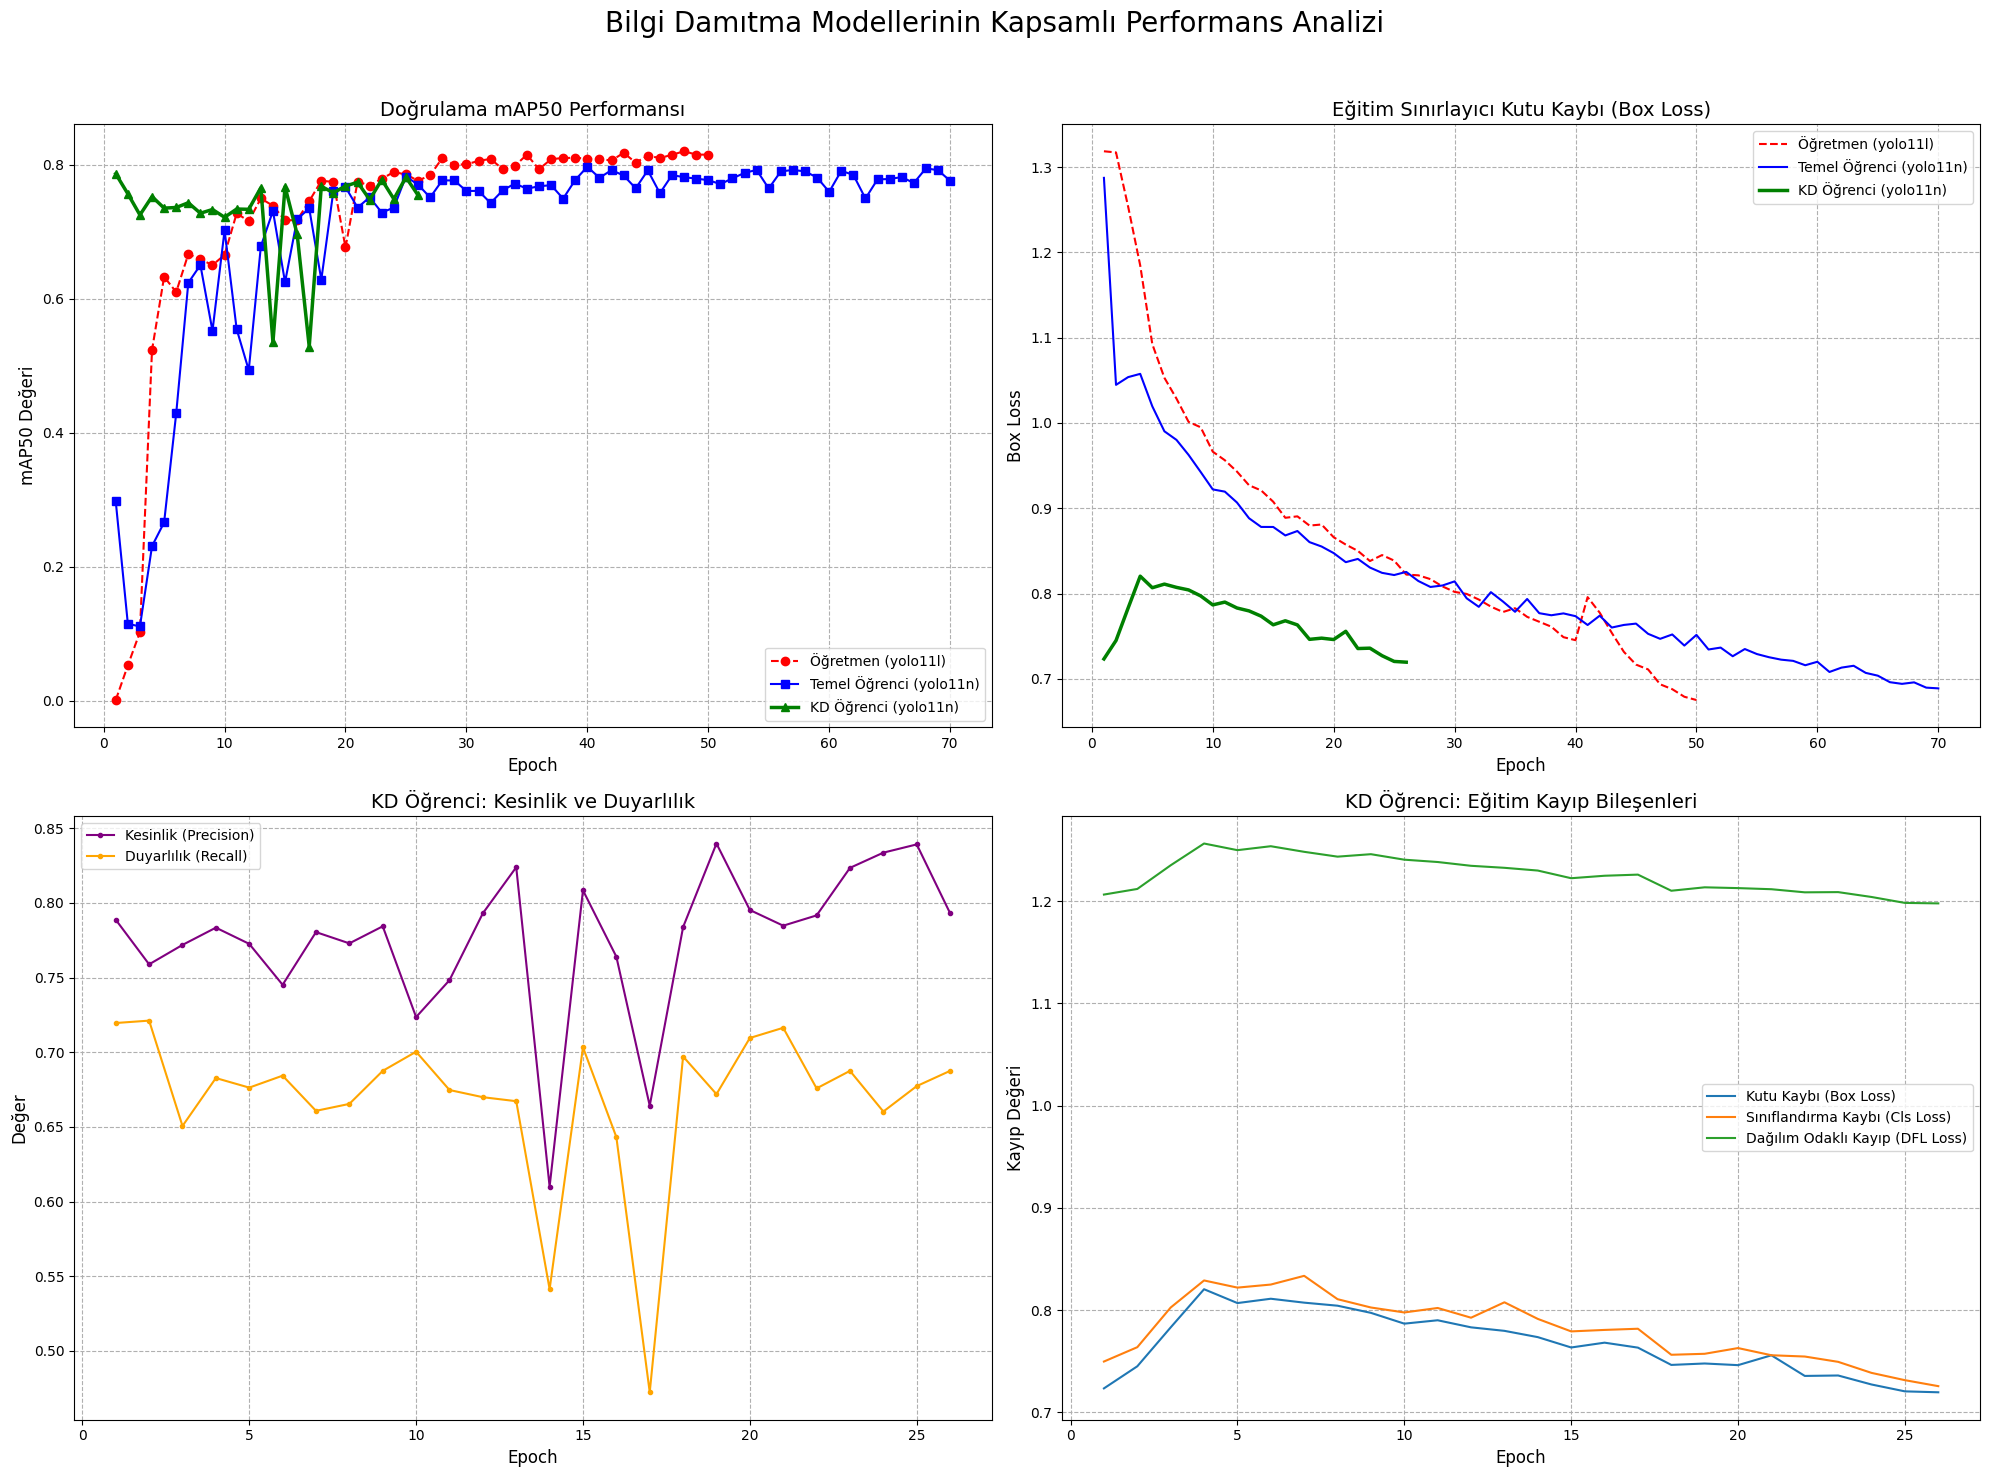

In [3]:
# YOLOv11 Bilgi Damıtma - Akademik Sonuç Görselleştirme Betiği
# Bu betik, daha önce tamamlanmış eğitimlerin sonuçlarını okur ve
# akademik yayınlar için uygun, çoklu ve detaylı grafikler oluşturur.

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

print("Akademik sonuçları görselleştirme betiği başlatıldı...")

# --- Dizin Ayarları ---
# Lütfen bu dizinlerin Colab'deki yapınızla eşleştiğinden emin olun.
BASE_DIR = Path.cwd() / 'yolo11_advanced_kd'
TEACHER_DIR = BASE_DIR / 'teacher'
STUDENT_DIR = BASE_DIR / 'student'

# Eğitim klasörlerinin tam yollarını tanımla
teacher_results_path = TEACHER_DIR / 'teacher_training' / 'results.csv'
student_base_results_path = STUDENT_DIR / 'student_base_training' / 'results.csv'
student_kd_results_path = STUDENT_DIR / 'student_final_kd_finetune' / 'results.csv'

print(f"Öğretmen sonuçları aranıyor: {teacher_results_path}")
print(f"Temel öğrenci sonuçları aranıyor: {student_base_results_path}")
print(f"KD öğrenci sonuçları aranıyor: {student_kd_results_path}")

# --- Görselleştirme ---
try:
    # CSV dosyalarını oku
    df_teacher = pd.read_csv(teacher_results_path)
    df_student_base = pd.read_csv(student_base_results_path)
    df_student_kd = pd.read_csv(student_kd_results_path)

    # Sütun adlarındaki olası boşlukları temizle
    for df in [df_teacher, df_student_base, df_student_kd]:
        df.columns = df.columns.str.strip()

    # Tek bir figür üzerinde 2x2'lik bir alt grafik alanı oluştur
    fig, axs = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Bilgi Damıtma Modellerinin Kapsamlı Performans Analizi', fontsize=20, y=0.95)

    # --- 1. Grafik: mAP50 Karşılaştırması (Ana Grafik) ---
    ax = axs[0, 0]
    ax.plot(df_teacher['epoch'], df_teacher['metrics/mAP50(B)'], label='Öğretmen (yolo11l)', marker='o', linestyle='--', color='red')
    ax.plot(df_student_base['epoch'], df_student_base['metrics/mAP50(B)'], label='Temel Öğrenci (yolo11n)', marker='s', color='blue')
    ax.plot(df_student_kd['epoch'], df_student_kd['metrics/mAP50(B)'], label='KD Öğrenci (yolo11n)', marker='^', color='green', linewidth=2.5)
    ax.set_title('Doğrulama mAP50 Performansı', fontsize=14)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('mAP50 Değeri', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--')

    # --- 2. Grafik: Eğitim Kayıp (Box Loss) Karşılaştırması ---
    ax = axs[0, 1]
    ax.plot(df_teacher['epoch'], df_teacher['train/box_loss'], label='Öğretmen (yolo11l)', linestyle='--', color='red')
    ax.plot(df_student_base['epoch'], df_student_base['train/box_loss'], label='Temel Öğrenci (yolo11n)', color='blue')
    ax.plot(df_student_kd['epoch'], df_student_kd['train/box_loss'], label='KD Öğrenci (yolo11n)', color='green', linewidth=2.5)
    ax.set_title('Eğitim Sınırlayıcı Kutu Kaybı (Box Loss)', fontsize=14)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Box Loss', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--')

    # --- 3. Grafik: Kesinlik (Precision) ve Duyarlılık (Recall) Karşılaştırması ---
    ax = axs[1, 0]
    ax.plot(df_student_kd['epoch'], df_student_kd['metrics/precision(B)'], label='Kesinlik (Precision)', marker='.', color='purple')
    ax.plot(df_student_kd['epoch'], df_student_kd['metrics/recall(B)'], label='Duyarlılık (Recall)', marker='.', color='orange')
    ax.set_title('KD Öğrenci: Kesinlik ve Duyarlılık', fontsize=14)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Değer', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--')

    # --- 4. Grafik: KD Öğrenci Detaylı Kayıp Analizi ---
    ax = axs[1, 1]
    ax.plot(df_student_kd['epoch'], df_student_kd['train/box_loss'], label='Kutu Kaybı (Box Loss)')
    ax.plot(df_student_kd['epoch'], df_student_kd['train/cls_loss'], label='Sınıflandırma Kaybı (Cls Loss)')
    ax.plot(df_student_kd['epoch'], df_student_kd['train/dfl_loss'], label='Dağılım Odaklı Kayıp (DFL Loss)')
    ax.set_title('KD Öğrenci: Eğitim Kayıp Bileşenleri', fontsize=14)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Kayıp Değeri', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--')

    # Genel düzeni ayarla ve kaydet
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    save_path = BASE_DIR / 'kd_academic_performance_analysis.png'
    plt.savefig(save_path, dpi=300) # Akademik yayın için yüksek çözünürlük (300 DPI)

    print("\n" + "="*50)
    print(f"✅ Akademik analiz grafikleri başarıyla oluşturuldu ve kaydedildi!")
    print(f"   Dosya Yolu: {save_path}")
    print("="*50)

    # Grafiği Colab'de göster
    plt.show()

except FileNotFoundError as e:
    print(f"\n❌ HATA: Grafik çizilemedi. Sonuç dosyası bulunamadı.")
    print(f"   Eksik dosya: {e.filename}")
    print("   Lütfen eğitimlerin tamamlandığından ve klasör yollarının doğru olduğundan emin olun.")
except KeyError as e:
    print(f"\n❌ HATA: CSV dosyasında beklenen sütun bulunamadı: {e}")
    print("   Lütfen 'results.csv' dosyalarınızın içeriğini kontrol edin.")
except Exception as e:
    print(f"\n❌ HATA: Grafik çizilirken beklenmedik bir sorun oluştu: {e}")



Akademik sonuçları görselleştirme betiği başlatıldı...
Öğretmen sonuçları aranıyor: /content/yolo11_advanced_kd/teacher/teacher_training/results.csv
Temel öğrenci sonuçları aranıyor: /content/yolo11_advanced_kd/student/student_base_training/results.csv
KD öğrenci sonuçları aranıyor: /content/yolo11_advanced_kd/student/student_final_kd_finetune/results.csv

✅ Kapsamlı akademik analiz grafikleri başarıyla oluşturuldu ve kaydedildi!
   Dosya Yolu: /content/yolo11_advanced_kd/kd_academic_performance_analysis_6_plots.png


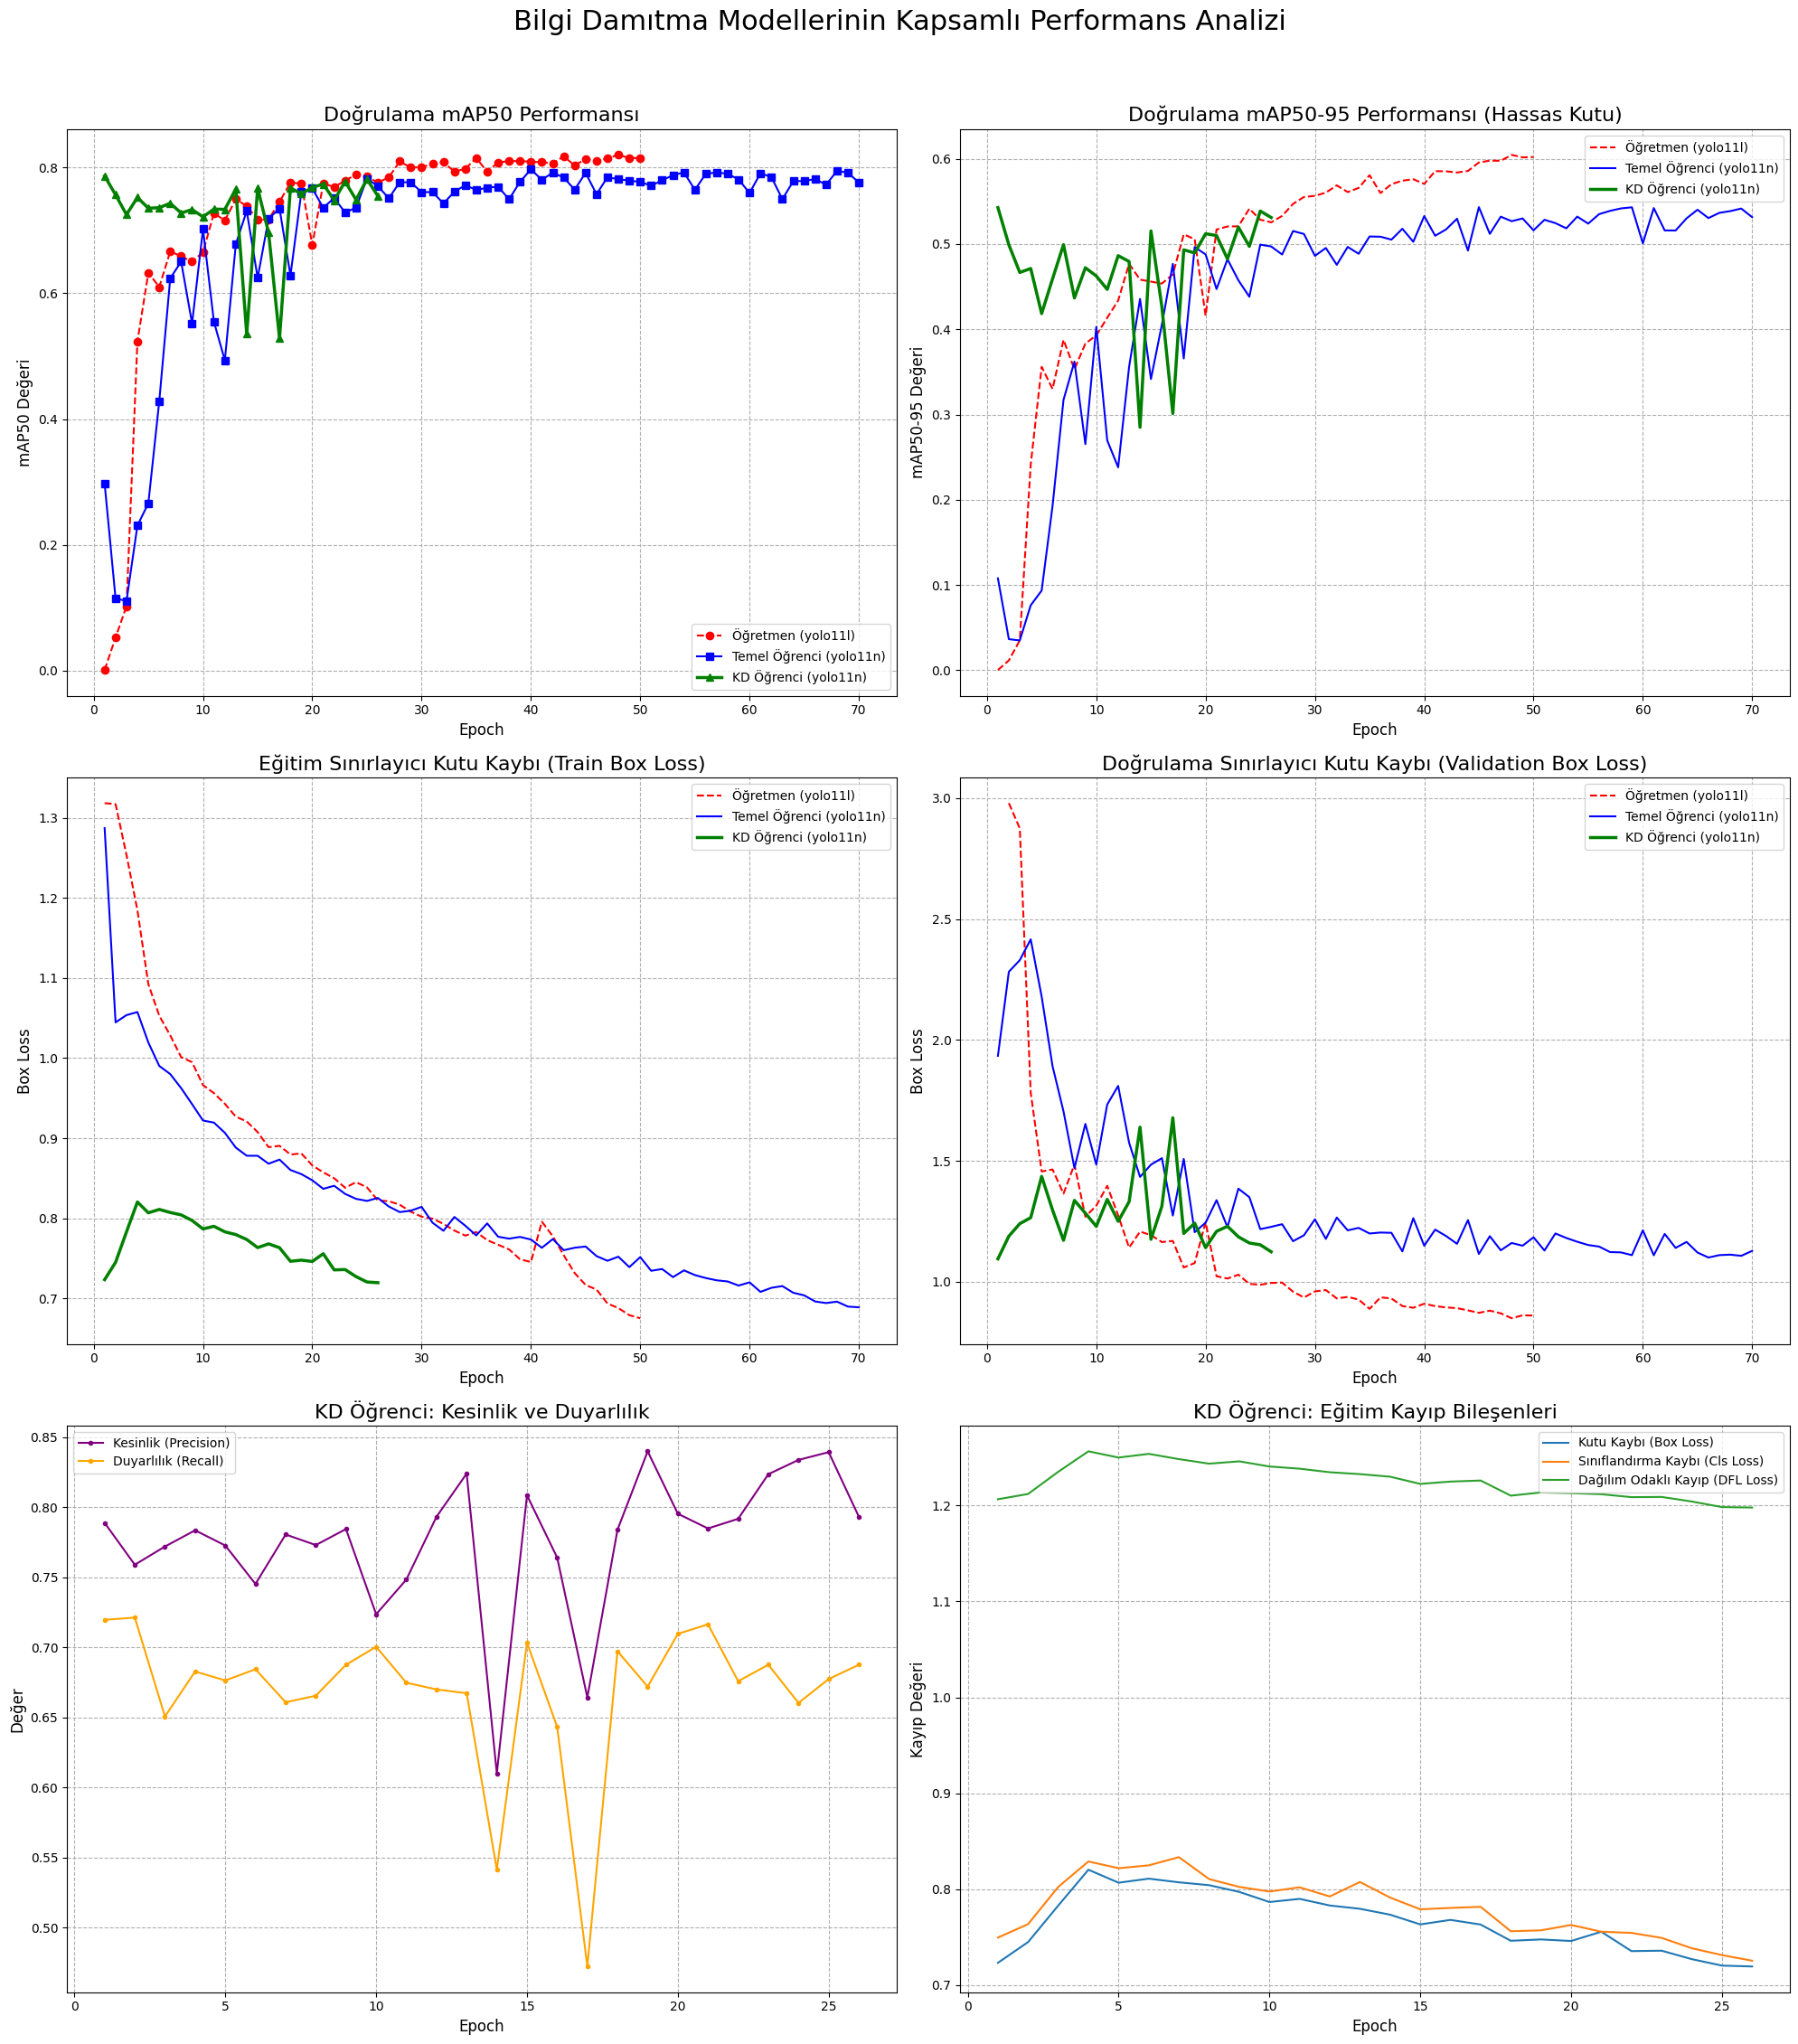

In [4]:
# YOLOv11 Bilgi Damıtma - Kapsamlı Akademik Sonuç Görselleştirme Betiği
# Bu betik, tamamlanmış eğitimlerin sonuçlarını okur ve
# akademik yayınlar için uygun, 6 farklı ve detaylı grafik oluşturur.

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

print("Akademik sonuçları görselleştirme betiği başlatıldı...")

# --- Dizin Ayarları ---
# Lütfen bu dizinlerin Colab'deki yapınızla eşleştiğinden emin olun.
BASE_DIR = Path.cwd() / 'yolo11_advanced_kd'
TEACHER_DIR = BASE_DIR / 'teacher'
STUDENT_DIR = BASE_DIR / 'student'

# Eğitim klasörlerinin tam yollarını tanımla
teacher_results_path = TEACHER_DIR / 'teacher_training' / 'results.csv'
student_base_results_path = STUDENT_DIR / 'student_base_training' / 'results.csv'
student_kd_results_path = STUDENT_DIR / 'student_final_kd_finetune' / 'results.csv'

print(f"Öğretmen sonuçları aranıyor: {teacher_results_path}")
print(f"Temel öğrenci sonuçları aranıyor: {student_base_results_path}")
print(f"KD öğrenci sonuçları aranıyor: {student_kd_results_path}")

# --- Görselleştirme ---
try:
    # CSV dosyalarını oku
    df_teacher = pd.read_csv(teacher_results_path)
    df_student_base = pd.read_csv(student_base_results_path)
    df_student_kd = pd.read_csv(student_kd_results_path)

    # Sütun adlarındaki olası boşlukları temizle
    for df in [df_teacher, df_student_base, df_student_kd]:
        df.columns = df.columns.str.strip()

    # Tek bir figür üzerinde 3x2'lik bir alt grafik alanı oluştur
    fig, axs = plt.subplots(3, 2, figsize=(20, 24))
    fig.suptitle('Bilgi Damıtma Modellerinin Kapsamlı Performans Analizi', fontsize=22, y=0.97)

    # --- 1. Grafik: mAP50 Karşılaştırması (Ana Metrik) ---
    ax = axs[0, 0]
    ax.plot(df_teacher['epoch'], df_teacher['metrics/mAP50(B)'], label='Öğretmen (yolo11l)', marker='o', linestyle='--', color='red')
    ax.plot(df_student_base['epoch'], df_student_base['metrics/mAP50(B)'], label='Temel Öğrenci (yolo11n)', marker='s', color='blue')
    ax.plot(df_student_kd['epoch'], df_student_kd['metrics/mAP50(B)'], label='KD Öğrenci (yolo11n)', marker='^', color='green', linewidth=2.5)
    ax.set_title('Doğrulama mAP50 Performansı', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('mAP50 Değeri', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--')

    # --- 2. Grafik: mAP50-95 Karşılaştırması (Katı Metrik) ---
    ax = axs[0, 1]
    ax.plot(df_teacher['epoch'], df_teacher['metrics/mAP50-95(B)'], label='Öğretmen (yolo11l)', linestyle='--', color='red')
    ax.plot(df_student_base['epoch'], df_student_base['metrics/mAP50-95(B)'], label='Temel Öğrenci (yolo11n)', color='blue')
    ax.plot(df_student_kd['epoch'], df_student_kd['metrics/mAP50-95(B)'], label='KD Öğrenci (yolo11n)', color='green', linewidth=2.5)
    ax.set_title('Doğrulama mAP50-95 Performansı (Hassas Kutu)', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('mAP50-95 Değeri', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--')

    # --- 3. Grafik: Eğitim Sınırlayıcı Kutu Kaybı (Box Loss) ---
    ax = axs[1, 0]
    ax.plot(df_teacher['epoch'], df_teacher['train/box_loss'], label='Öğretmen (yolo11l)', linestyle='--', color='red')
    ax.plot(df_student_base['epoch'], df_student_base['train/box_loss'], label='Temel Öğrenci (yolo11n)', color='blue')
    ax.plot(df_student_kd['epoch'], df_student_kd['train/box_loss'], label='KD Öğrenci (yolo11n)', color='green', linewidth=2.5)
    ax.set_title('Eğitim Sınırlayıcı Kutu Kaybı (Train Box Loss)', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Box Loss', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--')

    # --- 4. Grafik: Doğrulama Sınırlayıcı Kutu Kaybı (Validation Box Loss) ---
    ax = axs[1, 1]
    ax.plot(df_teacher['epoch'], df_teacher['val/box_loss'], label='Öğretmen (yolo11l)', linestyle='--', color='red')
    ax.plot(df_student_base['epoch'], df_student_base['val/box_loss'], label='Temel Öğrenci (yolo11n)', color='blue')
    ax.plot(df_student_kd['epoch'], df_student_kd['val/box_loss'], label='KD Öğrenci (yolo11n)', color='green', linewidth=2.5)
    ax.set_title('Doğrulama Sınırlayıcı Kutu Kaybı (Validation Box Loss)', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Box Loss', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--')

    # --- 5. Grafik: Kesinlik (Precision) ve Duyarlılık (Recall) ---
    ax = axs[2, 0]
    ax.plot(df_student_kd['epoch'], df_student_kd['metrics/precision(B)'], label='Kesinlik (Precision)', marker='.', color='purple')
    ax.plot(df_student_kd['epoch'], df_student_kd['metrics/recall(B)'], label='Duyarlılık (Recall)', marker='.', color='orange')
    ax.set_title('KD Öğrenci: Kesinlik ve Duyarlılık', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Değer', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--')

    # --- 6. Grafik: KD Öğrenci Detaylı Kayıp Analizi ---
    ax = axs[2, 1]
    ax.plot(df_student_kd['epoch'], df_student_kd['train/box_loss'], label='Kutu Kaybı (Box Loss)')
    ax.plot(df_student_kd['epoch'], df_student_kd['train/cls_loss'], label='Sınıflandırma Kaybı (Cls Loss)')
    ax.plot(df_student_kd['epoch'], df_student_kd['train/dfl_loss'], label='Dağılım Odaklı Kayıp (DFL Loss)')
    ax.set_title('KD Öğrenci: Eğitim Kayıp Bileşenleri', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Kayıp Değeri', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--')

    # Genel düzeni ayarla ve kaydet
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    save_path = BASE_DIR / 'kd_academic_performance_analysis_6_plots.png'
    plt.savefig(save_path, dpi=300) # Akademik yayın için yüksek çözünürlük (300 DPI)

    print("\n" + "="*50)
    print(f"✅ Kapsamlı akademik analiz grafikleri başarıyla oluşturuldu ve kaydedildi!")
    print(f"   Dosya Yolu: {save_path}")
    print("="*50)

    # Grafiği Colab'de göster
    plt.show()

except FileNotFoundError as e:
    print(f"\n❌ HATA: Grafik çizilemedi. Sonuç dosyası bulunamadı.")
    print(f"   Eksik dosya: {e.filename}")
    print("   Lütfen eğitimlerin tamamlandığından ve klasör yollarının doğru olduğundan emin olun.")
except KeyError as e:
    print(f"\n❌ HATA: CSV dosyasında beklenen sütun bulunamadı: {e}")
    print("   Lütfen 'results.csv' dosyalarınızın içeriğini kontrol edin.")
except Exception as e:
    print(f"\n❌ HATA: Grafik çizilirken beklenmedik bir sorun oluştu: {e}")



Academic results visualization script started...
Searching for Teacher results: /content/yolo11_advanced_kd/teacher/teacher_training/results.csv
Searching for Base Student results: /content/yolo11_advanced_kd/student/student_base_training/results.csv
Searching for KD Student results: /content/yolo11_advanced_kd/student/student_final_kd_finetune/results.csv

✅ Comprehensive academic analysis plots created and saved successfully!
   File Path: /content/yolo11_advanced_kd/kd_academic_performance_analysis_6_plots.png


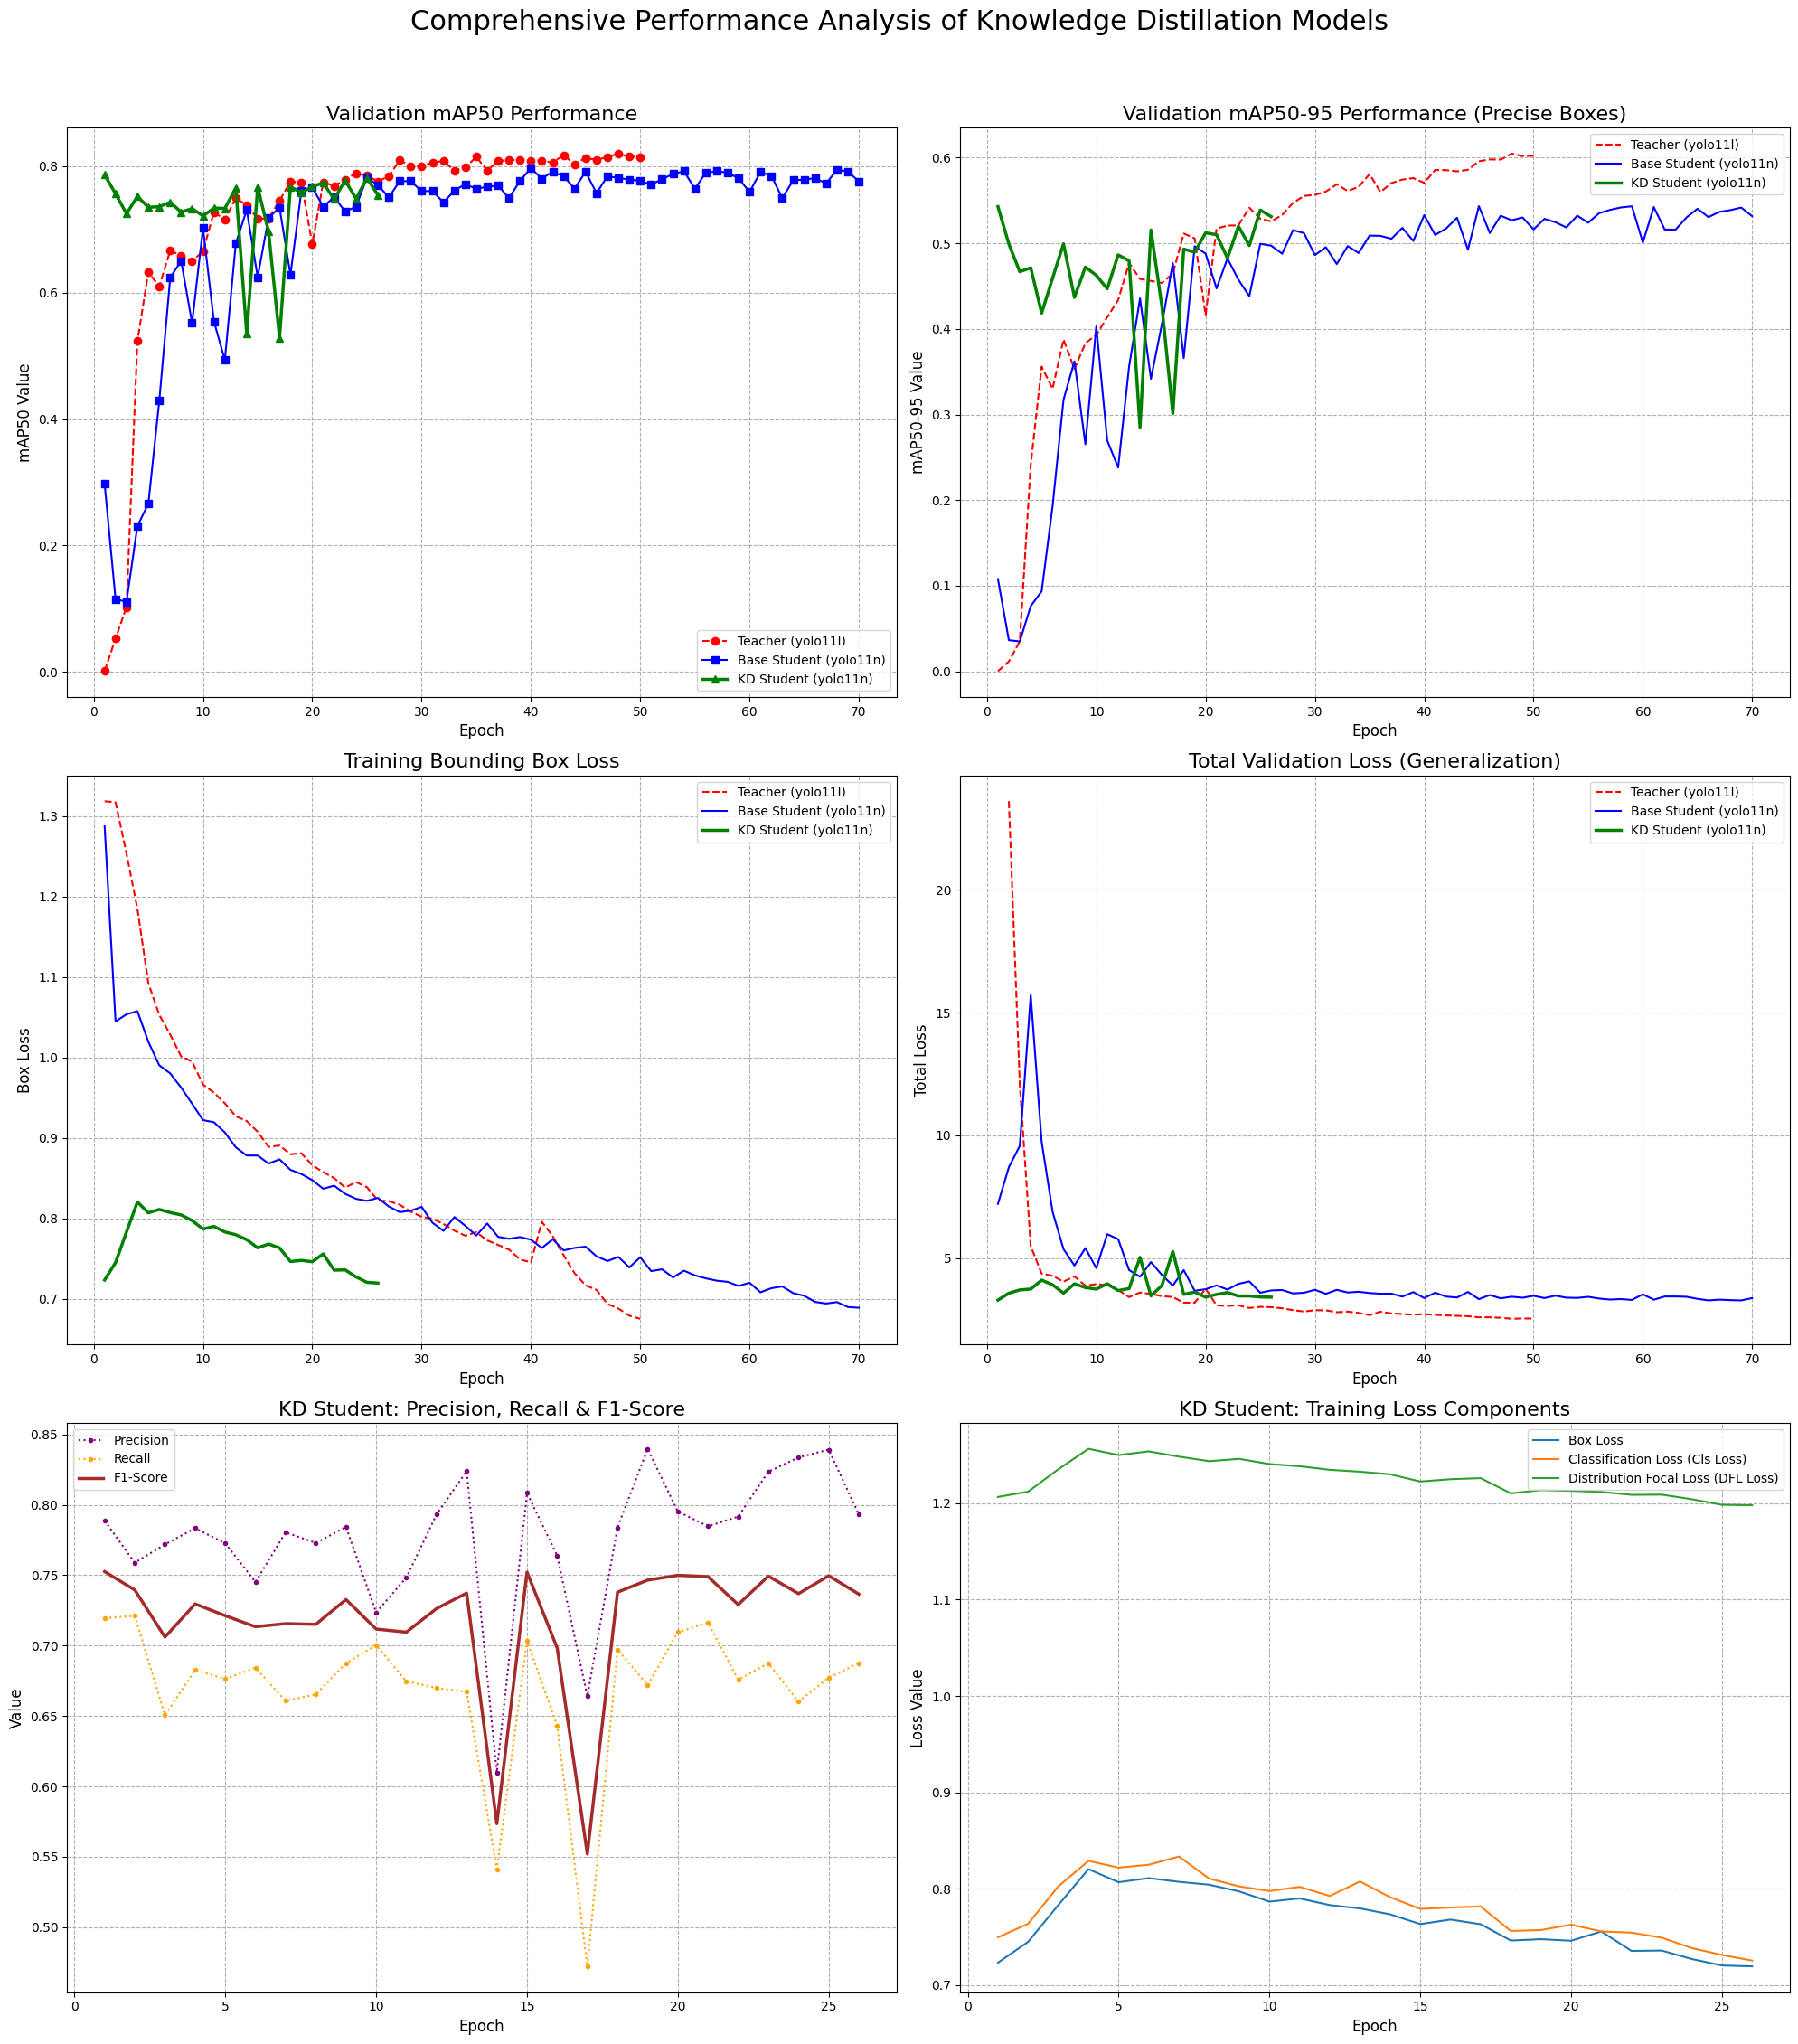

In [7]:
# YOLOv11 Knowledge Distillation - Comprehensive Academic Results Visualization Script
# This script reads the results of completed trainings and
# creates 6 different and detailed plots suitable for academic publications.

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

print("Academic results visualization script started...")

# --- Directory Settings ---
# Please ensure these directories match your structure in Colab.
BASE_DIR = Path.cwd() / 'yolo11_advanced_kd'
TEACHER_DIR = BASE_DIR / 'teacher'
STUDENT_DIR = BASE_DIR / 'student'

# Define the full paths for the training folders
teacher_results_path = TEACHER_DIR / 'teacher_training' / 'results.csv'
student_base_results_path = STUDENT_DIR / 'student_base_training' / 'results.csv'
student_kd_results_path = STUDENT_DIR / 'student_final_kd_finetune' / 'results.csv'

print(f"Searching for Teacher results: {teacher_results_path}")
print(f"Searching for Base Student results: {student_base_results_path}")
print(f"Searching for KD Student results: {student_kd_results_path}")

# --- Visualization ---
try:
    # Read the CSV files
    df_teacher = pd.read_csv(teacher_results_path)
    df_student_base = pd.read_csv(student_base_results_path)
    df_student_kd = pd.read_csv(student_kd_results_path)

    # Strip potential leading/trailing spaces from column names
    for df in [df_teacher, df_student_base, df_student_kd]:
        df.columns = df.columns.str.strip()
        # Calculate Total Validation Loss
        df['val/total_loss'] = df['val/box_loss'] + df['val/cls_loss'] + df['val/dfl_loss']

    # Calculate F1 Score for the KD student
    precision = df_student_kd['metrics/precision(B)']
    recall = df_student_kd['metrics/recall(B)']
    df_student_kd['metrics/f1_score(B)'] = 2 * (precision * recall) / (precision + recall + 1e-9)


    # Create a 3x2 subplot grid on a single figure
    fig, axs = plt.subplots(3, 2, figsize=(20, 24))
    fig.suptitle('Comprehensive Performance Analysis of Knowledge Distillation Models', fontsize=22, y=0.97)

    # --- Plot 1: mAP50 Comparison (Primary Metric) ---
    ax = axs[0, 0]
    ax.plot(df_teacher['epoch'], df_teacher['metrics/mAP50(B)'], label='Teacher (yolo11l)', marker='o', linestyle='--', color='red')
    ax.plot(df_student_base['epoch'], df_student_base['metrics/mAP50(B)'], label='Base Student (yolo11n)', marker='s', color='blue')
    ax.plot(df_student_kd['epoch'], df_student_kd['metrics/mAP50(B)'], label='KD Student (yolo11n)', marker='^', color='green', linewidth=2.5)
    ax.set_title('Validation mAP50 Performance', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('mAP50 Value', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--')

    # --- Plot 2: mAP50-95 Comparison (Strict Metric) ---
    ax = axs[0, 1]
    ax.plot(df_teacher['epoch'], df_teacher['metrics/mAP50-95(B)'], label='Teacher (yolo11l)', linestyle='--', color='red')
    ax.plot(df_student_base['epoch'], df_student_base['metrics/mAP50-95(B)'], label='Base Student (yolo11n)', color='blue')
    ax.plot(df_student_kd['epoch'], df_student_kd['metrics/mAP50-95(B)'], label='KD Student (yolo11n)', color='green', linewidth=2.5)
    ax.set_title('Validation mAP50-95 Performance (Precise Boxes)', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('mAP50-95 Value', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--')

    # --- Plot 3: Training Bounding Box Loss ---
    ax = axs[1, 0]
    ax.plot(df_teacher['epoch'], df_teacher['train/box_loss'], label='Teacher (yolo11l)', linestyle='--', color='red')
    ax.plot(df_student_base['epoch'], df_student_base['train/box_loss'], label='Base Student (yolo11n)', color='blue')
    ax.plot(df_student_kd['epoch'], df_student_kd['train/box_loss'], label='KD Student (yolo11n)', color='green', linewidth=2.5)
    ax.set_title('Training Bounding Box Loss', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Box Loss', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--')

    # --- Plot 4: Total Validation Loss (NEW) ---
    ax = axs[1, 1]
    ax.plot(df_teacher['epoch'], df_teacher['val/total_loss'], label='Teacher (yolo11l)', linestyle='--', color='red')
    ax.plot(df_student_base['epoch'], df_student_base['val/total_loss'], label='Base Student (yolo11n)', color='blue')
    ax.plot(df_student_kd['epoch'], df_student_kd['val/total_loss'], label='KD Student (yolo11n)', color='green', linewidth=2.5)
    ax.set_title('Total Validation Loss (Generalization)', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Total Loss', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--')

    # --- Plot 5: Precision, Recall, and F1-Score (ENHANCED) ---
    ax = axs[2, 0]
    ax.plot(df_student_kd['epoch'], df_student_kd['metrics/precision(B)'], label='Precision', marker='.', linestyle=':', color='purple')
    ax.plot(df_student_kd['epoch'], df_student_kd['metrics/recall(B)'], label='Recall', marker='.', linestyle=':', color='orange')
    ax.plot(df_student_kd['epoch'], df_student_kd['metrics/f1_score(B)'], label='F1-Score', color='brown', linewidth=2.5)
    ax.set_title('KD Student: Precision, Recall & F1-Score', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Value', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--')

    # --- Plot 6: KD Student Detailed Loss Analysis ---
    ax = axs[2, 1]
    ax.plot(df_student_kd['epoch'], df_student_kd['train/box_loss'], label='Box Loss')
    ax.plot(df_student_kd['epoch'], df_student_kd['train/cls_loss'], label='Classification Loss (Cls Loss)')
    ax.plot(df_student_kd['epoch'], df_student_kd['train/dfl_loss'], label='Distribution Focal Loss (DFL Loss)')
    ax.set_title('KD Student: Training Loss Components', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss Value', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--')

    # Adjust overall layout and save
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    save_path = BASE_DIR / 'kd_academic_performance_analysis_6_plots.png'
    plt.savefig(save_path, dpi=300) # High resolution for academic publications (300 DPI)

    print("\n" + "="*50)
    print(f"✅ Comprehensive academic analysis plots created and saved successfully!")
    print(f"   File Path: {save_path}")
    print("="*50)

    # Show the plot in Colab
    plt.show()

except FileNotFoundError as e:
    print(f"\n❌ ERROR: Could not plot. Results file not found.")
    print(f"   Missing file: {e.filename}")
    print("   Please ensure that the trainings have completed and the folder paths are correct.")
except KeyError as e:
    print(f"\n❌ ERROR: Expected column not found in the CSV file: {e}")
    print("   Please check the content of your 'results.csv' files.")
except Exception as e:
    print(f"\n❌ ERROR: An unexpected error occurred while plotting: {e}")



Academic results visualization script started...
Searching for Teacher results: /content/yolo11_advanced_kd/teacher/teacher_training/results.csv
Searching for Base Student results: /content/yolo11_advanced_kd/student/student_base_training/results.csv
Searching for KD Student results: /content/yolo11_advanced_kd/student/student_final_kd_finetune/results.csv

           ACADEMIC RESULTS SUMMARY TABLE
                 Model Best mAP50 Best mAP50-95  Best Epoch Final Val. Loss
     Teacher (yolo11l)     0.8199        0.6047          48          2.5388
Base Student (yolo11n)     0.7968        0.5329          40          3.3714
  KD Student (yolo11n)     0.7862        0.5428           1          3.4101


✅ Comprehensive academic analysis plots created and saved successfully!
   File Path: /content/yolo11_advanced_kd/kd_academic_performance_analysis_6_plots.png


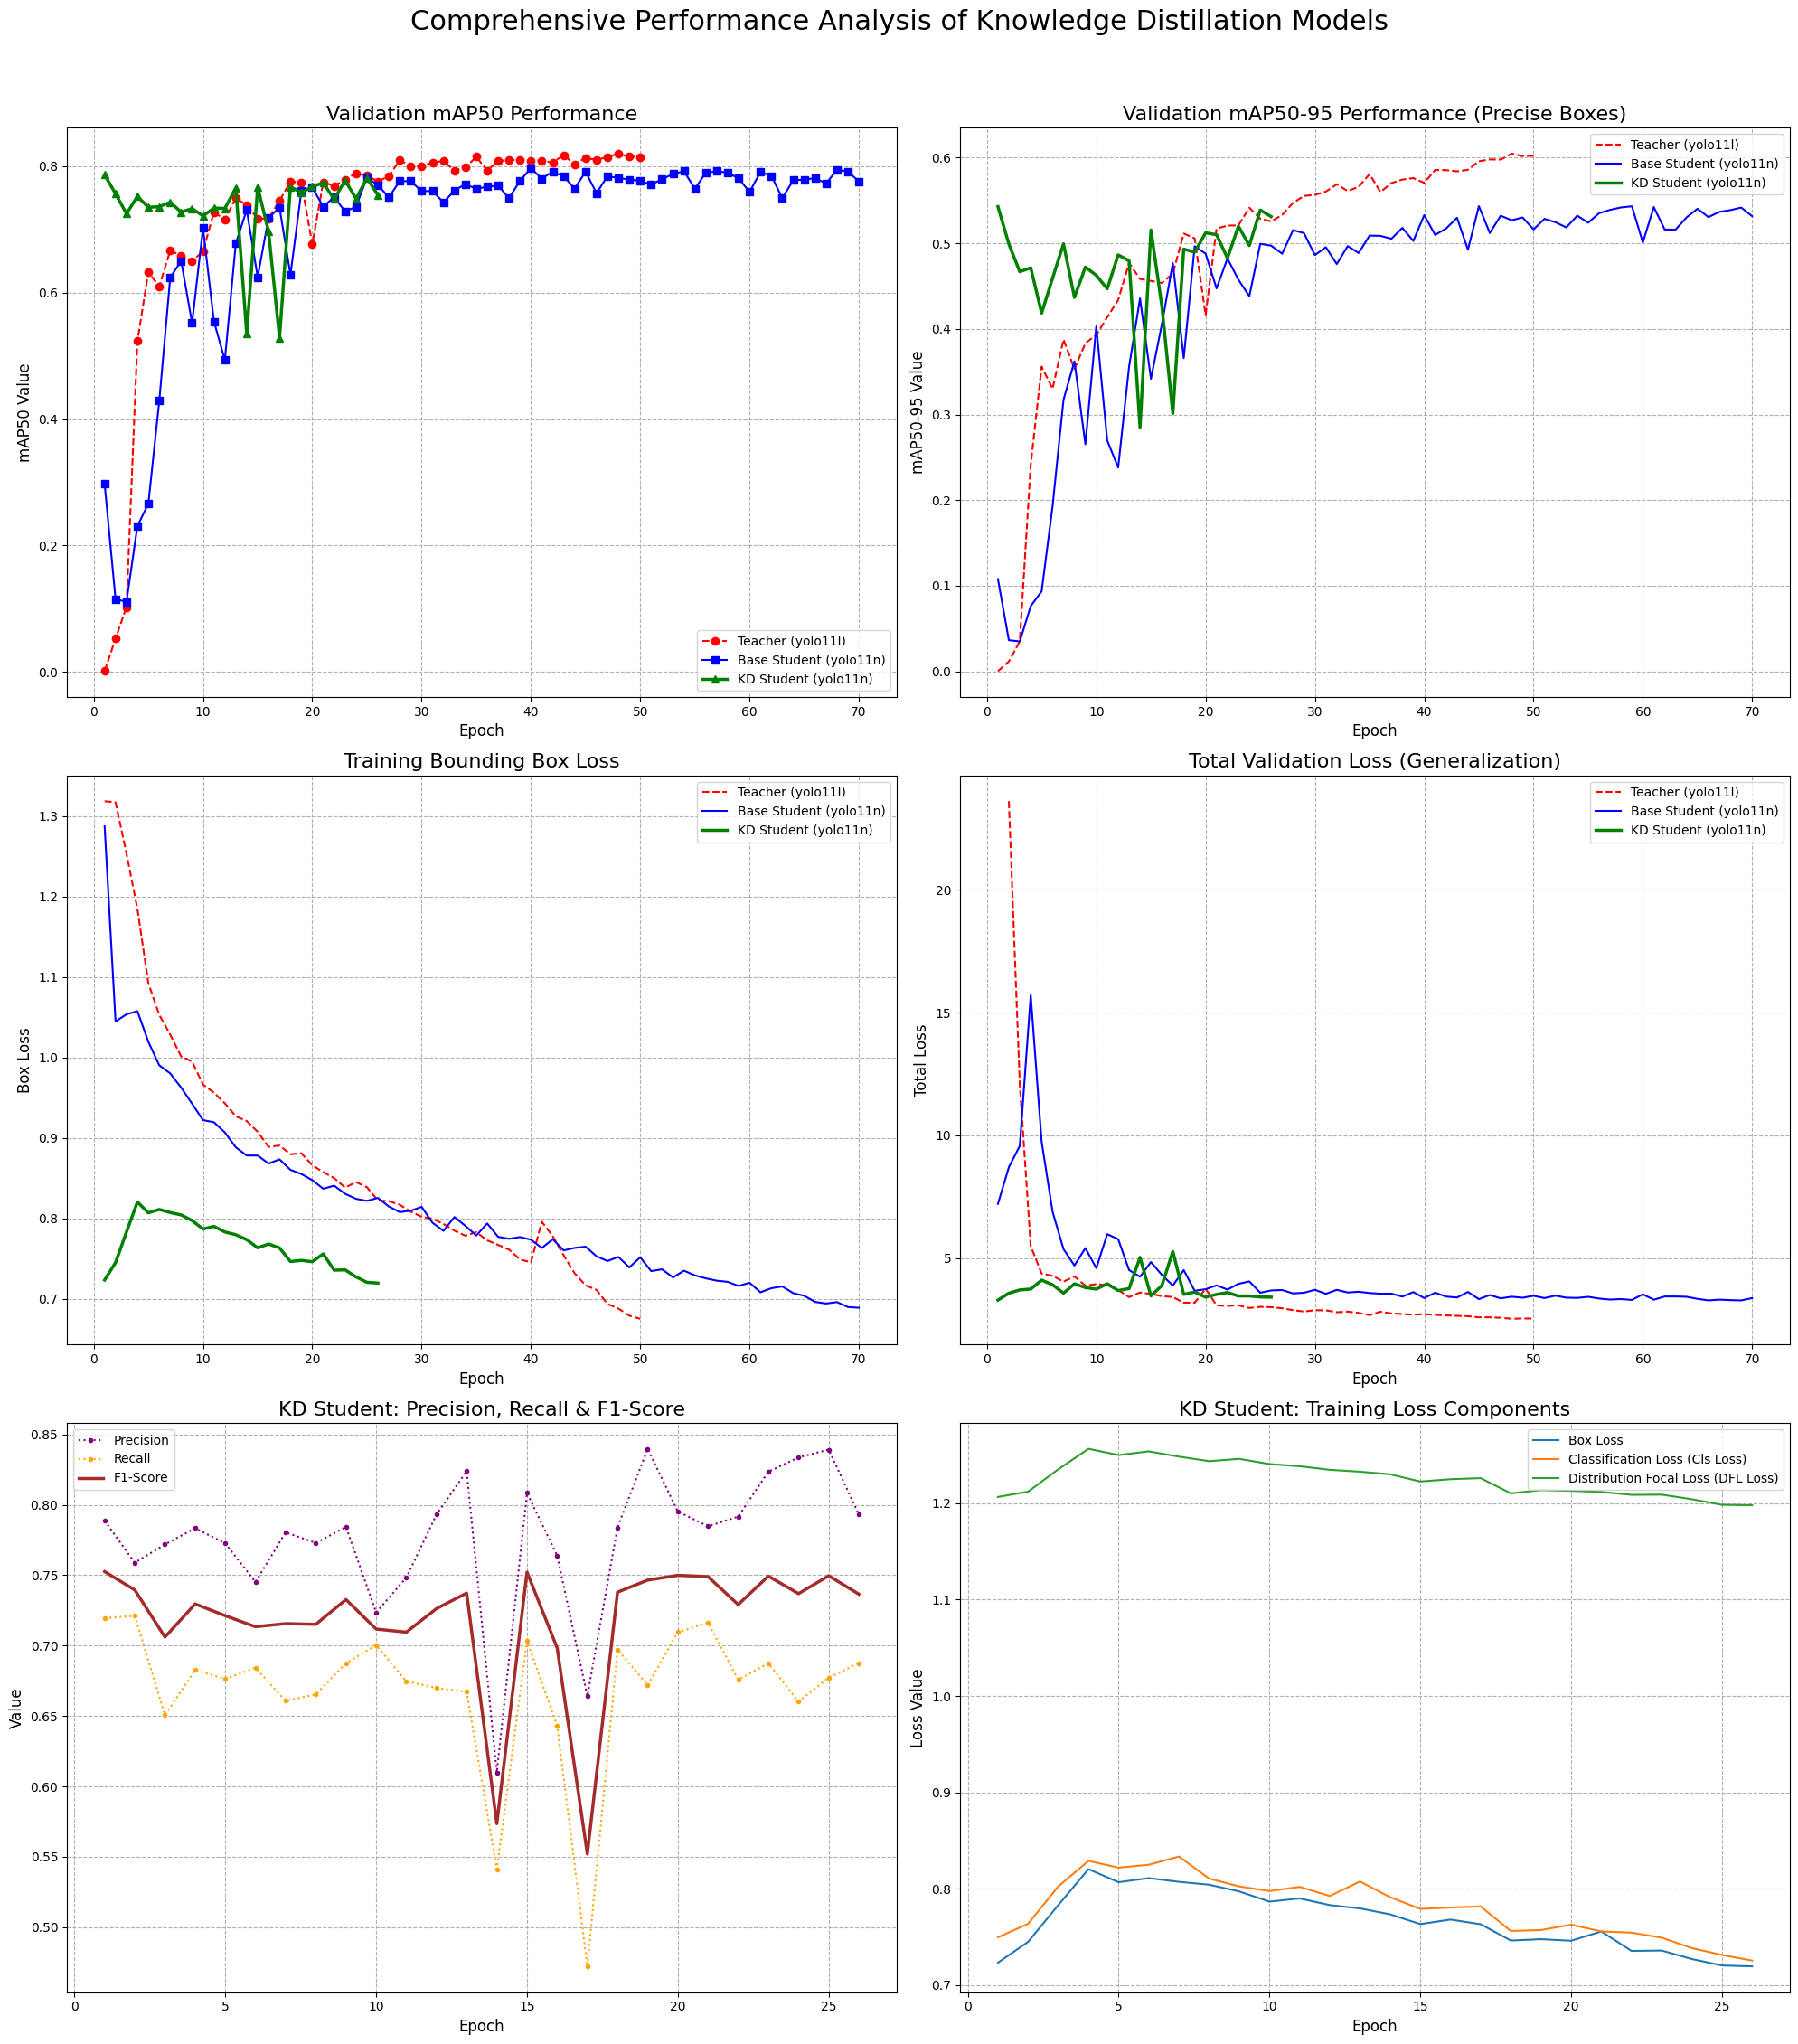

In [10]:
# YOLOv11 Knowledge Distillation - Comprehensive Academic Results Visualization Script
# This script reads the results of completed trainings and
# creates 6 different and detailed plots suitable for academic publications.

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

print("Academic results visualization script started...")

# --- Directory Settings ---
# Please ensure these directories match your structure in Colab.
BASE_DIR = Path.cwd() / 'yolo11_advanced_kd'
TEACHER_DIR = BASE_DIR / 'teacher'
STUDENT_DIR = BASE_DIR / 'student'

# Define the full paths for the training folders
teacher_results_path = TEACHER_DIR / 'teacher_training' / 'results.csv'
student_base_results_path = STUDENT_DIR / 'student_base_training' / 'results.csv'
student_kd_results_path = STUDENT_DIR / 'student_final_kd_finetune' / 'results.csv'

print(f"Searching for Teacher results: {teacher_results_path}")
print(f"Searching for Base Student results: {student_base_results_path}")
print(f"Searching for KD Student results: {student_kd_results_path}")

# --- Visualization ---
try:
    # Read the CSV files
    df_teacher = pd.read_csv(teacher_results_path)
    df_student_base = pd.read_csv(student_base_results_path)
    df_student_kd = pd.read_csv(student_kd_results_path)

    # Strip potential leading/trailing spaces from column names
    for df in [df_teacher, df_student_base, df_student_kd]:
        df.columns = df.columns.str.strip()
        # Calculate Total Validation Loss
        df['val/total_loss'] = df['val/box_loss'] + df['val/cls_loss'] + df['val/dfl_loss']

    # Calculate F1 Score for the KD student
    precision = df_student_kd['metrics/precision(B)']
    recall = df_student_kd['metrics/recall(B)']
    df_student_kd['metrics/f1_score(B)'] = 2 * (precision * recall) / (precision + recall + 1e-9)

    # --- Summary Table (NEW) ---
    print("\n" + "="*60)
    print("           ACADEMIC RESULTS SUMMARY TABLE")
    print("="*60)

    summary_data = []
    models = {
        "Teacher (yolo11l)": df_teacher,
        "Base Student (yolo11n)": df_student_base,
        "KD Student (yolo11n)": df_student_kd
    }

    for name, df in models.items():
        best_epoch_idx = df['metrics/mAP50(B)'].idxmax()
        best_row = df.loc[best_epoch_idx]
        summary_data.append({
            "Model": name,
            "Best mAP50": f"{best_row['metrics/mAP50(B)']:.4f}",
            "Best mAP50-95": f"{best_row['metrics/mAP50-95(B)']:.4f}",
            "Best Epoch": int(best_row['epoch']),
            "Final Val. Loss": f"{df.iloc[-1]['val/total_loss']:.4f}"
        })

    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    print("="*60 + "\n")


    # Create a 3x2 subplot grid on a single figure
    fig, axs = plt.subplots(3, 2, figsize=(20, 24))
    fig.suptitle('Comprehensive Performance Analysis of Knowledge Distillation Models', fontsize=22, y=0.97)

    # --- Plot 1: mAP50 Comparison (Primary Metric) ---
    ax = axs[0, 0]
    ax.plot(df_teacher['epoch'], df_teacher['metrics/mAP50(B)'], label='Teacher (yolo11l)', marker='o', linestyle='--', color='red')
    ax.plot(df_student_base['epoch'], df_student_base['metrics/mAP50(B)'], label='Base Student (yolo11n)', marker='s', color='blue')
    ax.plot(df_student_kd['epoch'], df_student_kd['metrics/mAP50(B)'], label='KD Student (yolo11n)', marker='^', color='green', linewidth=2.5)
    ax.set_title('Validation mAP50 Performance', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('mAP50 Value', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--')

    # --- Plot 2: mAP50-95 Comparison (Strict Metric) ---
    ax = axs[0, 1]
    ax.plot(df_teacher['epoch'], df_teacher['metrics/mAP50-95(B)'], label='Teacher (yolo11l)', linestyle='--', color='red')
    ax.plot(df_student_base['epoch'], df_student_base['metrics/mAP50-95(B)'], label='Base Student (yolo11n)', color='blue')
    ax.plot(df_student_kd['epoch'], df_student_kd['metrics/mAP50-95(B)'], label='KD Student (yolo11n)', color='green', linewidth=2.5)
    ax.set_title('Validation mAP50-95 Performance (Precise Boxes)', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('mAP50-95 Value', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--')

    # --- Plot 3: Training Bounding Box Loss ---
    ax = axs[1, 0]
    ax.plot(df_teacher['epoch'], df_teacher['train/box_loss'], label='Teacher (yolo11l)', linestyle='--', color='red')
    ax.plot(df_student_base['epoch'], df_student_base['train/box_loss'], label='Base Student (yolo11n)', color='blue')
    ax.plot(df_student_kd['epoch'], df_student_kd['train/box_loss'], label='KD Student (yolo11n)', color='green', linewidth=2.5)
    ax.set_title('Training Bounding Box Loss', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Box Loss', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--')

    # --- Plot 4: Total Validation Loss (NEW) ---
    ax = axs[1, 1]
    ax.plot(df_teacher['epoch'], df_teacher['val/total_loss'], label='Teacher (yolo11l)', linestyle='--', color='red')
    ax.plot(df_student_base['epoch'], df_student_base['val/total_loss'], label='Base Student (yolo11n)', color='blue')
    ax.plot(df_student_kd['epoch'], df_student_kd['val/total_loss'], label='KD Student (yolo11n)', color='green', linewidth=2.5)
    ax.set_title('Total Validation Loss (Generalization)', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Total Loss', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--')

    # --- Plot 5: Precision, Recall, and F1-Score (ENHANCED) ---
    ax = axs[2, 0]
    ax.plot(df_student_kd['epoch'], df_student_kd['metrics/precision(B)'], label='Precision', marker='.', linestyle=':', color='purple')
    ax.plot(df_student_kd['epoch'], df_student_kd['metrics/recall(B)'], label='Recall', marker='.', linestyle=':', color='orange')
    ax.plot(df_student_kd['epoch'], df_student_kd['metrics/f1_score(B)'], label='F1-Score', color='brown', linewidth=2.5)
    ax.set_title('KD Student: Precision, Recall & F1-Score', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Value', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--')

    # --- Plot 6: KD Student Detailed Loss Analysis ---
    ax = axs[2, 1]
    ax.plot(df_student_kd['epoch'], df_student_kd['train/box_loss'], label='Box Loss')
    ax.plot(df_student_kd['epoch'], df_student_kd['train/cls_loss'], label='Classification Loss (Cls Loss)')
    ax.plot(df_student_kd['epoch'], df_student_kd['train/dfl_loss'], label='Distribution Focal Loss (DFL Loss)')
    ax.set_title('KD Student: Training Loss Components', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss Value', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--')

    # Adjust overall layout and save
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    save_path = BASE_DIR / 'kd_academic_performance_analysis_6_plots.png'
    plt.savefig(save_path, dpi=300) # High resolution for academic publications (300 DPI)

    print("\n" + "="*50)
    print(f"✅ Comprehensive academic analysis plots created and saved successfully!")
    print(f"   File Path: {save_path}")
    print("="*50)

    # Show the plot in Colab
    plt.show()

except FileNotFoundError as e:
    print(f"\n❌ ERROR: Could not plot. Results file not found.")
    print(f"   Missing file: {e.filename}")
    print("   Please ensure that the trainings have completed and the folder paths are correct.")
except KeyError as e:
    print(f"\n❌ ERROR: Expected column not found in the CSV file: {e}")
    print("   Please check the content of your 'results.csv' files.")
except Exception as e:
    print(f"\n❌ ERROR: An unexpected error occurred while plotting: {e}")



In [11]:
# BÖLÜM 7: SONUÇLARI İNDİR
# ==============================================================================
print("Bölüm 7: Sonuçlar sıkıştırılıp indiriliyor...")

output_filename = 'yolo11_advanced_kd_results'
print(f"'{BASE_DIR}' klasörü sıkıştırılıyor...")
shutil.make_archive(output_filename, 'zip', BASE_DIR)
print(f"Sıkıştırma tamamlandı: '{output_filename}.zip' oluşturuldu.")

try:
    from google.colab import files
    print("İndirme başlatılıyor...")
    files.download(f'{output_filename}.zip')
except ImportError:
    print("Bu kod Google Colab dışında çalıştırıldığı için otomatik indirme yapılamadı.")
    print(f"Lütfen '{output_filename}.zip' dosyasını manuel olarak indirin.")

print("-" * 50)
print("Tüm işlemler tamamlandı.")

Bölüm 7: Sonuçlar sıkıştırılıp indiriliyor...
'/content/yolo11_advanced_kd' klasörü sıkıştırılıyor...
Sıkıştırma tamamlandı: 'yolo11_advanced_kd_results.zip' oluşturuldu.
İndirme başlatılıyor...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------------------------------------
Tüm işlemler tamamlandı.
